# An example of reference mapping using user-owned reference dataset

In [ ]:
import numpy as np
import scanpy as sc
import sys
import os
import warnings
import torch
from pathlib import Path
import json
import pandas as pd
from scipy.stats import mode


sys.path.insert(0, "../")
from scgpt.loss import masked_mse_loss, masked_relative_error
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt import logger
from scgpt import SubsetsBatchSampler
import sklearn
# extra dependency for similarity search
try:
    import hnswlib
    hnswlib_imported = True
except ImportError:
    hnswlib_imported = False
    print("hnswlib not installed! We highly recommend installing it for fast similarity search.")
    print("To install it, run: pip install hnswlib")


## some  functions

In [2]:
def get_batch_cell_embeddings(
    adata,
    cell_embedding_mode: str = "cls",
    model=None,
    vocab=None,
    max_length=1200,
    model_configs=None,
    gene_ids=None,
    use_batch_labels=False,
) -> np.ndarray:
    """
    Get the cell embeddings for a batch of cells.

    Args:
        adata (AnnData): The AnnData object.
        gene_embs (np.ndarray): The gene embeddings, shape (len(vocab), d_emb).
        count_matrix (np.ndarray): The count matrix.

    Returns:
        np.ndarray: The cell embeddings.
    """
    count_matrix = (
        adata.layers["counts"]
        if isinstance(adata.layers["counts"], np.ndarray)
        else adata.layers["counts"].A
    )

    # gene vocabulary ids
    if gene_ids is None:
        gene_ids = np.array(adata.var["id_in_vocab"])
        assert np.all(gene_ids >= 0)

    if use_batch_labels:
        batch_ids = np.array(adata.obs["batch_id"].tolist())

    elif cell_embedding_mode == "cls":
        tokenized_all = tokenize_and_pad_batch(
            count_matrix,
            gene_ids,
            max_len=max_length,
            vocab=vocab,
            pad_token=model_configs["pad_token"],
            pad_value=model_configs["pad_value"],
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=False,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[model_configs["pad_token"]])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=64,
                batch_labels=None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )
    else:
        raise ValueError(f"Unknown cell embedding mode: {cell_embedding_mode}")
    return cell_embeddings

In [3]:
adata = sc.read_h5ad("../data/annotation_pancreas/demo_train.h5ad")
cell_type_key = "Celltype"
assert cell_type_key in adata.obs

gene_col = "index"
if gene_col == "index":
    adata.var["index"] = adata.var.index
else:
    assert gene_col in adata.var

n_hvg = max_seq_len = 1200
DO_HVG = False
HAS_BATCH = batch_key = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model_dir = Path("../save/scGPT_human")
vocab_file = model_dir / "vocab.json"
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]

# vocabulary
vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)
adata.var["id_in_vocab"] = [
    vocab[gene] if gene in vocab else -1 for gene in adata.var[gene_col]
]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
logger.info(
    f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
    f"in vocabulary of size {len(vocab)}."
)
adata = adata[:, adata.var["id_in_vocab"] >= 0]


with open(model_config_file, "r") as f:
    model_configs = json.load(f)

scGPT - INFO - match 2999/3000 genes in vocabulary of size 60697.


In [5]:
data_is_raw = adata.X.max() > 30
print ("data is raw: ", data_is_raw)
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=False,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg if DO_HVG else False,
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=51,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="counts",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key=batch_key if HAS_BATCH else None)

vocab.set_default_index(vocab["<pad>"])
genes = adata.var[gene_col].tolist()
gene_ids = np.array(vocab(genes), dtype=int)

if HAS_BATCH:
    adata.obs["batch_id"] = adata.obs[batch_key].astype("category").cat.codes.values
else:
    adata.obs["batch_id"] = (
        adata.obs[cell_type_key].astype("category").cat.codes.values
    )
batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

# # Tokenize input
if isinstance(adata.layers["counts"], np.ndarray):
    all_counts = adata.layers["counts"]
else:
    all_counts = adata.layers["counts"].A

num_of_non_zero_genes = [
    np.count_nonzero(all_counts[i]) for i in range(all_counts.shape[0])
]

max_length = np.max(num_of_non_zero_genes) + 1  # plus 1 for appending <cls>
max_length = min(max_length, max_seq_len + 1)


data is raw:  False
scGPT - INFO - Filtering cells by counts ...


/h/haotian/.conda/envs/scgpt/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...


In [6]:
model = TransformerModel(
    ntoken=len(vocab),
    d_model=model_configs["embsize"],
    nhead=model_configs["nheads"],
    d_hid=model_configs["d_hid"],
    nlayers=model_configs["nlayers"],
    nlayers_cls=model_configs["n_layers_cls"],
    n_cls=1,
    vocab=vocab,
    dropout=model_configs["dropout"],
    pad_token=model_configs["pad_token"],
    pad_value=model_configs["pad_value"],
    do_mvc=True,
    do_dab=False,
    use_batch_labels=False,
    # num_batch_labels=num_batch_types,
    domain_spec_batchnorm=False,
    explicit_zero_prob=False,
    use_fast_transformer=True,
    fast_transformer_backend="flash",
    pre_norm=False,
)

try:
    model.load_state_dict(torch.load(model_file, map_location=device))
except:
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    # for k, v in pretrained_dict.items():
    #     logger.info(f"Loading params {k} with shape {v.shape}")
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
model.to(device)

model.eval()

Using simple batchnorm instead of domain specific batchnorm


TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (bn): BatchNorm1d(512, eps=6.1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
   

In [7]:
ref_cell_embeddings = get_batch_cell_embeddings(
    adata,
    cell_embedding_mode="cls",
    model=model,
    vocab=vocab,
    max_length=max_length,
    model_configs=model_configs,
    gene_ids=gene_ids,
    use_batch_labels=False,
)

100%|██████████| 166/166 [00:22<00:00,  7.30it/s]


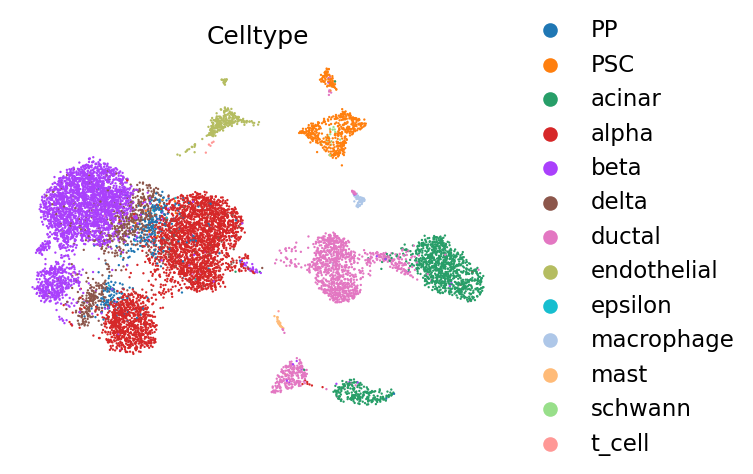

In [8]:
# Optional step to visualize the reference dataset using the embeddings
ref_embed_adata = sc.AnnData(
    ref_cell_embeddings,
    obs=pd.DataFrame(adata.obs))

sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

In [9]:
test_adata = sc.read_h5ad("../data/annotation_pancreas/demo_test.h5ad")
if gene_col == "index":
    test_adata.var["index"] = test_adata.var.index

test_adata.var["id_in_vocab"] = [
    vocab[gene] if gene in vocab else -1 for gene in test_adata.var[gene_col]
]
test_adata = test_adata[:, test_adata.var["id_in_vocab"] >= 0]
preprocessor(test_adata, batch_key=batch_key if HAS_BATCH else None)

scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...


/h/haotian/.conda/envs/scgpt/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


In [10]:
test_emebd = get_batch_cell_embeddings(
    test_adata,
    cell_embedding_mode="cls",
    model=model,
    vocab=vocab,
    max_length=max_length,
    model_configs=model_configs,
    gene_ids=np.array(vocab(test_adata.var[gene_col].tolist()), dtype=int),
    use_batch_labels=False,
)
    

100%|██████████| 66/66 [00:09<00:00,  7.12it/s]


In [11]:
# # optional step to visualize the dataset
# test_embed_adata = sc.AnnData(
#     test_emebd,
#     obs=pd.DataFrame(test_adata.obs))
# sc.pp.neighbors(test_embed_adata, use_rep="X")
# sc.tl.umap(test_embed_adata)
# sc.pl.umap(test_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

## referrence mapping

In [12]:
# Those functions are only used when hnswlib is not installed
def cos_sim(a, b):
    sims = a @ b.T
    sims /= np.linalg.norm(a) * np.linalg.norm(b, axis=1) 
    return sims[0]

def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)
        
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

def get_celltype(idx, adata):
    return adata.obs[cell_type_key][idx]

In [13]:
k = 10  # number of neighbors

if hnswlib_imported:
    # Declaring index, using most of the default parameters from https://github.com/nmslib/hnswlib
    p = hnswlib.Index(space = 'l2', dim = ref_cell_embeddings.shape[1]) # possible options are l2, cosine or ip
    p.init_index(max_elements = ref_cell_embeddings.shape[0], ef_construction = 200, M = 16)

    # Element insertion (can be called several times):
    p.add_items(ref_cell_embeddings, ids = np.arange(ref_cell_embeddings.shape[0]))

    # Controlling the recall by setting ef:
    p.set_ef(50) # ef should always be > k

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    labels, distances = p.knn_query(test_emebd, k = k)

idx_list=[i for i in range(test_emebd.shape[0])]
gt_list = []
pred_list = []
for k in idx_list:
    gt = test_adata.obs[cell_type_key][k]
    if hnswlib_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings)
    pred = mode(ref_embed_adata.obs[cell_type_key][idx], axis=0)
    gt_list.append(gt)
    pred_list.append(pred[0][0])

sklearn.metrics.accuracy_score(gt_list, pred_list)

0.7807017543859649

In [14]:
# optionally, the built index can be saved/loaded for future use
# if hnswlib_imported:
#     p.save_index("index.bin")
#     # the index can be loaded with
#     # p.load_index("index.bin", max_elements=...)